<a id = 'top-of-notebook'></a>
# LIME With Titanic Data

## Table of Contents
- [Project Setup](#project-setup)
- [Data Cleansing](#data-cleansing)
- [Data Modelling](#data-modelling)
- [Model Validation](#model-validation)
- [Explainability with LIME](#LIME)

<a id = 'project-setup'></a>
## Project Setup

In [1]:
try:
  import lime
except:
  !pip install lime
  import lime

     |████████████████████████████████| 275 kB 9.6 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=a469006abf69194f7a8d3039558397ea46d02baefacbee271e9ab2dcae35be00
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [2]:
# Importing necessary libraries
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import lime.lime_tabular

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the training data
df_train = pd.read_csv('/content/train.csv')

In [4]:
# Viewing the first few rows of the data
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


[*Return to top of notebook*](#top-of-notebook)

<a id = 'data-cleansing'></a>
## Data Cleansing & Feature Engineering
- Age -> Age Bins: child, teen, young adult, adult, elder, or unknown
- Cabin -> Section: A, B, C, or no cabin


#### 불필요한 칼럼 Drop

In [5]:
df_train.drop(columns = ['PassengerId', 'Name', 'Ticket'], inplace = True)

#### "Age" 칼럼 정보에서 "age_bins" feature 만들어 Age칼럼 대체

In [6]:
# Defining / instantiating the necessary variables
age_bins = [-3, -1, 12, 18, 25, 50, 100]
age_labels = ['unknown', 'child', 'teen', 'young_adult', 'adult', 'elder']
# Filling null age values
df_train['Age'] = df_train['Age'].fillna(-2)
# Binning the ages appropriate as defined via the variables above
df_train['Age_Bins'] = pd.cut(df_train['Age'], bins = age_bins, labels = age_labels)
# Dropping the now unneeded 'Age' feature
df_train.drop(columns = 'Age', inplace = True)

#### "Cabin" 칼럼 정보에서 맨 앞 한글자씩 따서 "Section" feature 만들어 Cabin 대체
C85 becomes "C"

In [7]:
# Grabbing the first character from the cabin section
df_train['Section'] = df_train['Cabin'].str[:1]
# Filling out the nulls
df_train['Section'].fillna('No Cabin', inplace = True)
# Dropping former 'Cabin' feature
df_train.drop(columns = 'Cabin', inplace = True)

#### "Embarked" 칼럼: 결측치 Unknown 으로 채우기

In [8]:
df_train['Embarked'] = df_train['Embarked'].fillna('Unknown')

#### Categorical variables 에 대해 One hot encoding

In [9]:
# Defining the categorical features
cat_feats = ['Pclass', 'Sex', 'Age_Bins', 'Embarked', 'Section']
# Instantiating OneHotEncoder
ohe = OneHotEncoder(categories = 'auto')
# Fitting the categorical variables to the encoder
cat_feats_encoded = ohe.fit_transform(df_train[cat_feats])
# Creating a DataFrame with the encoded value information
cat_df = pd.DataFrame(data = cat_feats_encoded.toarray(), columns = ohe.get_feature_names(cat_feats))

#### Numerical columns에 대해 Scaling

In [10]:
# Defining the numerical features
num_feats = ['SibSp', 'Parch', 'Fare']
# Instantiating the StandardScaler object
scaler = StandardScaler()
# Fitting the data to the scaler
num_feats_scaled = scaler.fit_transform(df_train[num_feats])
# Creating DataFrame with numerically scaled data
num_df = pd.DataFrame(data = num_feats_scaled, columns = num_feats)

#### Encoded & Scaled 된 Dataframes 들을 Concatenate 해서 "X" 라는 training data 만들기

In [11]:
X = pd.concat([cat_df, num_df], axis = 1)

#### df_train 에서 target 변수 ("Survived") 를 "y"로 지정

In [12]:
y = df_train[['Survived']]

#### Training / Validation Split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

[*Return to top of notebook*](#top-of-notebook)

<a id = 'data-modelling'></a>
## Data Modelling

#### GridSearch 로 optimal 파라미터 찾기

In [14]:
# Defining the random forest parameters
params = {'n_estimators': [10, 50, 100],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 5],
          'max_depth': [10, 20, 50]
         }
         
# Instantiating RandomForestClassifier object and GridSearch object
rfc = RandomForestClassifier()
clf = GridSearchCV(estimator = rfc,
                   param_grid = params)
# Fitting the training data to the GridSearch object
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 50],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]})

In [15]:
# Displaying the best parameters from the GridSearch object
clf.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10}

#### Training the model with the ideal params

In [16]:
# Instantiating RandomForestClassifier with ideal params
rfc = RandomForestClassifier(max_depth = 10,
                             min_samples_leaf = 2,
                             min_samples_split = 2,
                             n_estimators = 10)

# Fitting the training data to the model
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=10)

[*Return to top of notebook*](#top-of-notebook)

<a id = 'SHAP'></a>
## LIME 해석 위한 예시 데이터

#### Validation set 에서 Survived 와 did not survive 각각 준비

In [17]:
# Contentating X_val and y_val into single df_val set
df_val = pd.concat([X_val, y_val], axis = 1)

In [18]:
# Viewing first few rows of df_val to hopefully find 2 good candidates for our study
df_val.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_Bins_adult,Age_Bins_child,Age_Bins_elder,Age_Bins_teen,Age_Bins_unknown,Age_Bins_young_adult,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknown,Section_A,Section_B,Section_C,Section_D,Section_E,Section_F,Section_G,Section_No Cabin,Section_T,SibSp,Parch,Fare,Survived
709,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.432793,0.767630,-0.341452,1
439,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.474545,-0.473674,-0.437007,0
840,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.474545,-0.473674,-0.488854,0
720,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.474545,0.767630,0.016023,1
39,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.432793,-0.473674,-0.422074,1


In [19]:
# Noting the two respective people
person_1 = X_val.loc[[720]] # Survived
person_2 = X_val.loc[[439]] # Did not Survive

<a id = 'LIME'></a>
## Explainability with LIME

#### Instantiate LIME tabular
- Tabular Data 에 대해서 LIME represents a weighted combination of columns

- Args/Parameters

1) training_data: numpy 2d array

2) mode: "classification" or "regression"

3) feature_names: list of names (strings) corresponding to the columns
                in the training data

4) class_names: list of class names, ordered according to whatever the
                classifier is using. If not present, class names will be '0',
                '1', ...



In [20]:
# Importing LIME
import lime.lime_tabular

# Defining our LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                        mode = 'classification',
                                                        feature_names = X_train.columns,
                                                        class_names = ['Did Not Survive', 'Survived']
                                                        )

In [21]:
# Defining a quick function that can be used to explain the instance passed
predict_rfc_prob = lambda x: rfc.predict_proba(x).astype(float)

#### 두 가지 케이스에 대한 LIME 해석

#### 케이스 1)

 - 왼쪽 패널 ▶ Random Forest Model 은 "Survived" 일 거라고 거의 100% 예측했다

 - 중앙 패널 ▶ 특정 데이터 포인트의 각각의 feature 를 통해 (중요도순) 예측을 설명하고자 한다

     - 이 사람(sample)의 Sex_female feature에 대한 value는 1인데, 0<Sex_female<=1 에 해당되므로 "Survived" 라고 분류될 경향이 더 높다

   - 같은 원리로 이 샘플 Sex_male <= 0 에 해당하기 때문에, "Survived" 라고 분류될 경향이 더 높다
   - 이 샘플은 Age_Bins_child = 1 이므로, Age_Bins_child  > 0.00 에 해당하기 때문에 "Survived" 라고 분류될 경향이 더 높다

  - 그런가하면 Section_E 는 다른 해석을 내놓았다. Section_E= 0 이므로, Section_E <= 0.00 에 해당하기 때문에 "Did Not Survive" 라고 설명한다


- 오른쪽 패널 ▶ 이 샘플의 features & values 를 나타낸다

In [23]:
person_1_lime = lime_explainer.explain_instance(person_1.iloc[0].values,
                                                predict_rfc_prob,
                                                num_features = 10)
# person_1_lime.show_in_notebook()
# person_1_lime.save_to_file("person_1.html")

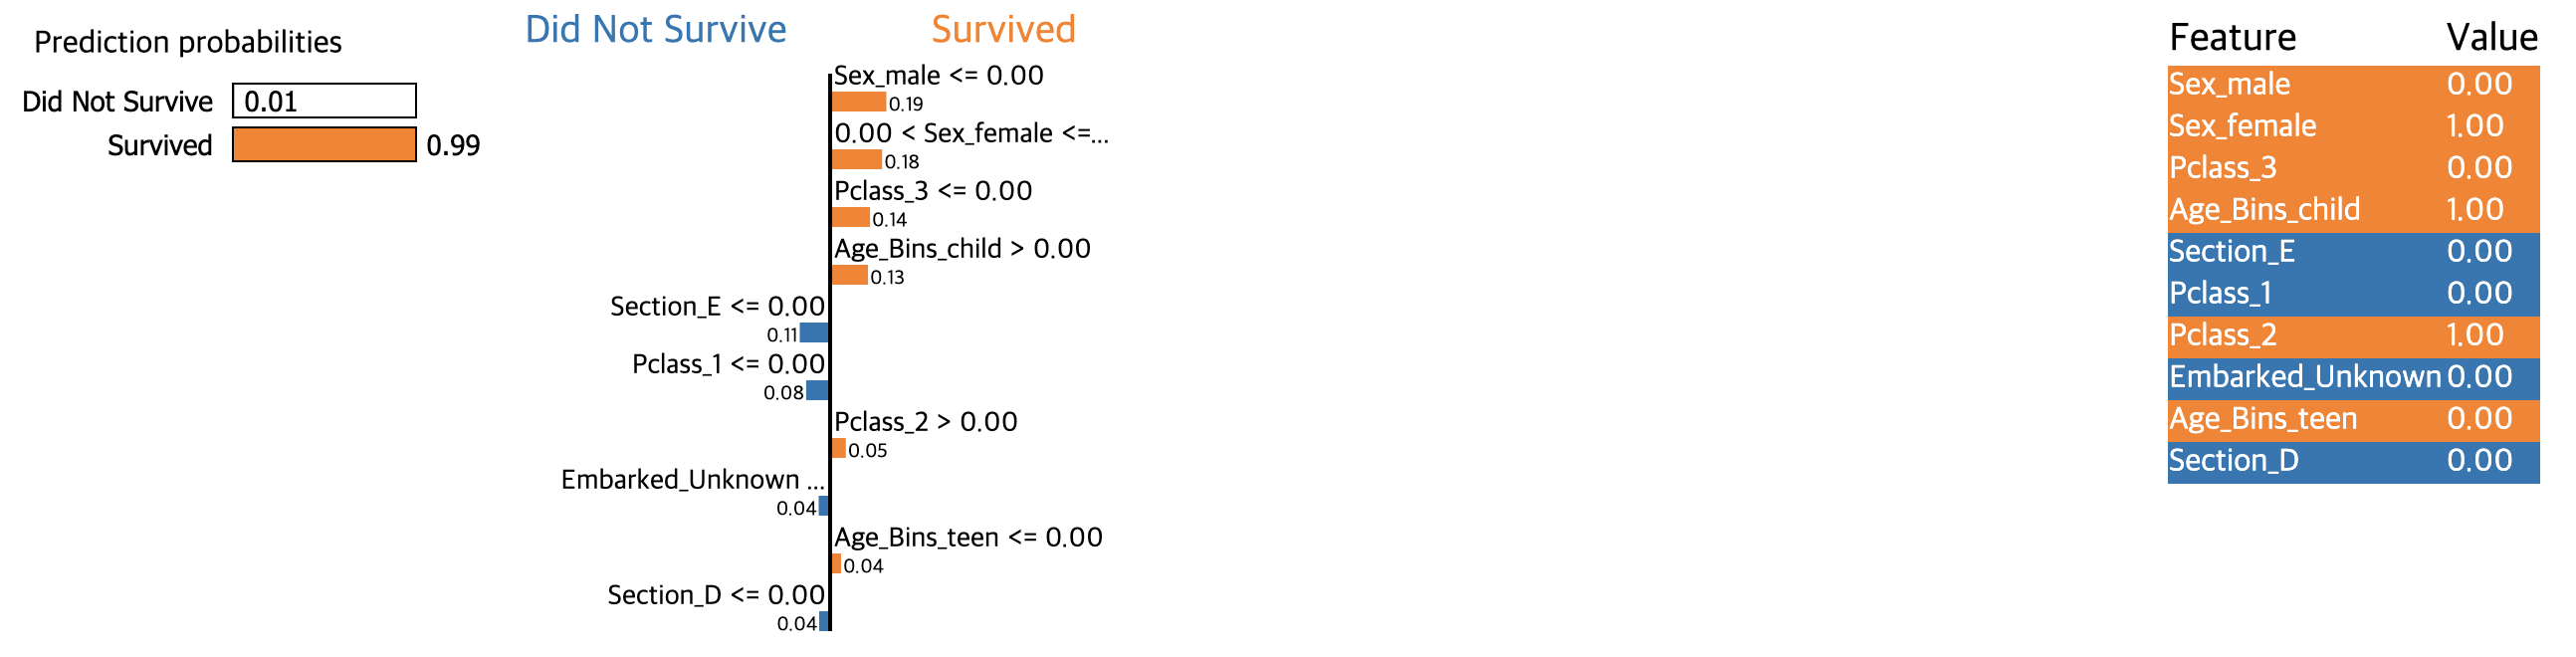

#### 케이스 2)

 - 왼쪽 패널 ▶ Random Forest Model 은 아래 샘플이 "Did Not Survive" 일 거라고 94% 예측했다

 - 중앙 패널 ▶ 특정 데이터 포인트의 각각의 feature 를 통해 (중요도순) 예측을 설명하고자 한다

     - 이 사람(sample)의 Sex_female feature에 대한 value는 1인데, 0<Sex_female<=1 에 해당되므로 "Did Not Survive" 라고 예측한 것에 대한 설명력이 높다 

   - 같은 원리로 이 샘플 Sex_male <= 0 에 해당하기 때문에, "Did Not Survive" 라고 분류될 경향이 더 높다

   - 이 샘플은 Age_Bins_child = 0 이므로, Age_Bins_child  <= 0.00 에 해당하기 때문에 "Did Not Survive" 라고 분류될 경향이 더 높다

   - 또한, 이 샘플은 Section_E = 0 이므로, Section_E  <= 0.00 에 해당하기 때문에 "Did Not Survive" 라고 분류될 경향이 더 높다

  - 그런가하면 Pclass_3 는 다른 해석을 내놓았다. Pclass_3= 0 이므로, Pclass_3 <= 0.00 에 해당하기 때문에 "Survived" 라고 설명한다


- 오른쪽 패널 ▶ 이 샘플의 features & values 를 나타낸다


In [24]:
person_2_lime = lime_explainer.explain_instance(person_2.iloc[0].values,
                                                predict_rfc_prob,
                                                num_features = 10)
# person_2_lime.show_in_notebook()
# person_2_lime.save_to_file("person_2.html")

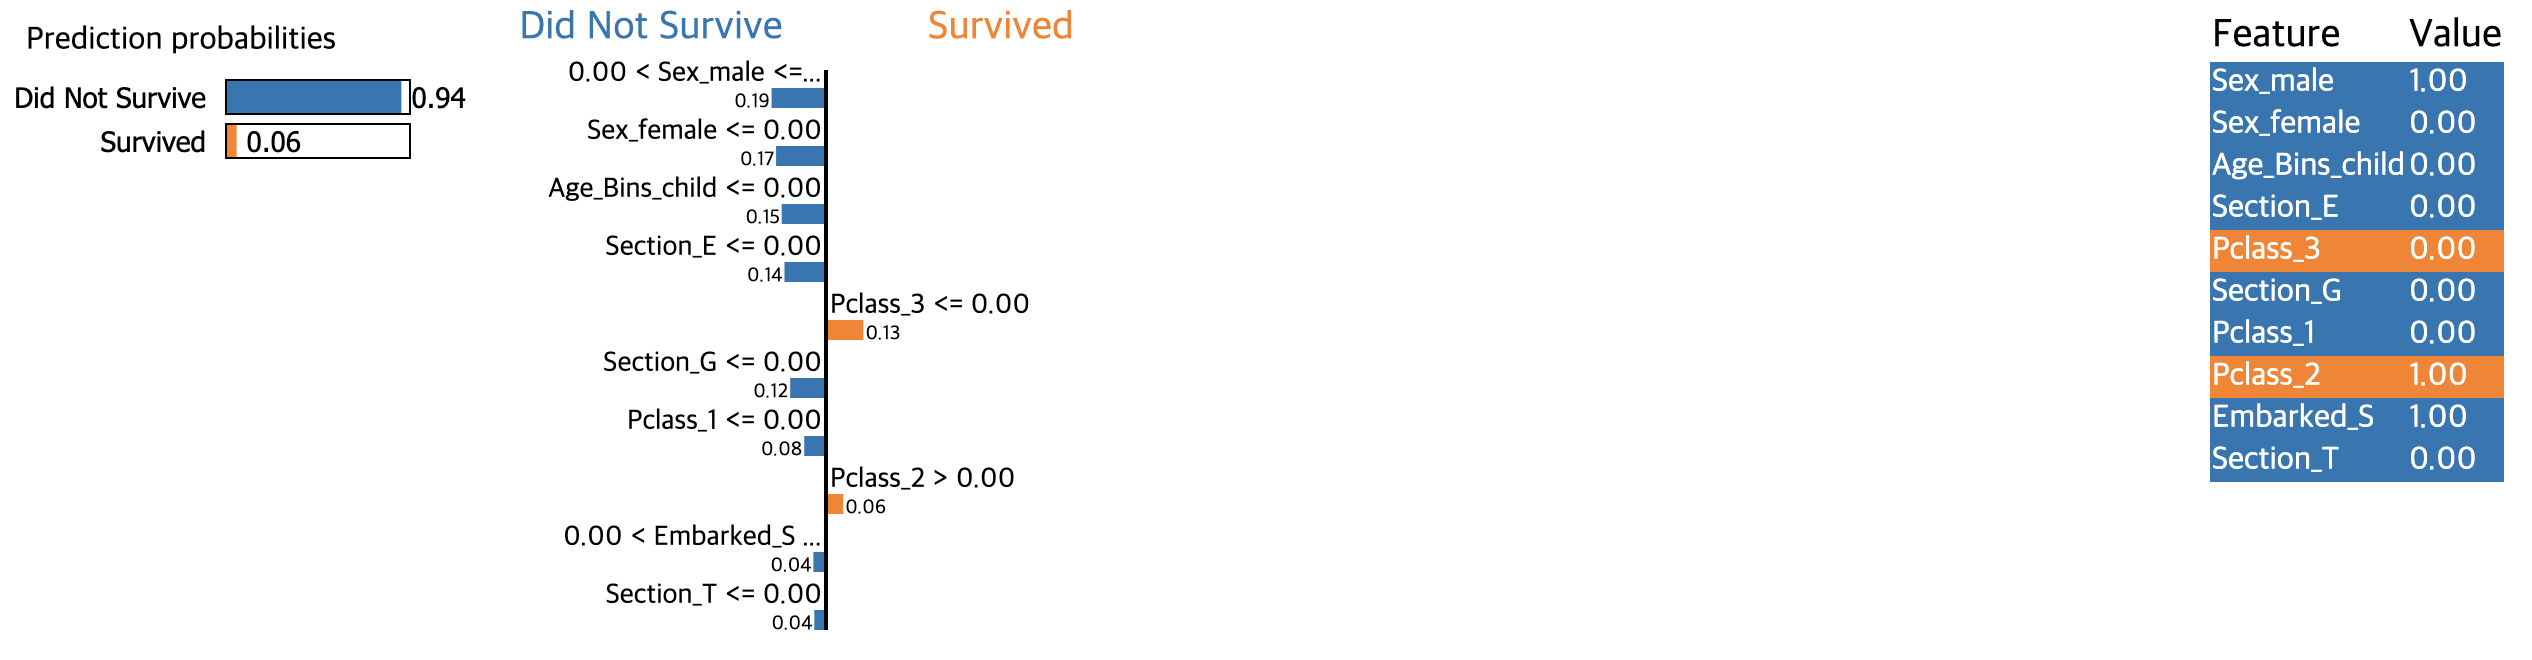

[*Return to top of notebook*](#top-of-notebook)

# To Do & consideration
- Categorical / Numerical 변수들이 많을 때 얼마나 많은 데이터를 갖고 설명해야할지에 대한 선?


# Reference
https://towardsdatascience.com/interpreting-black-box-ml-models-using-lime-4fa439be9885

